In [4]:
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import joblib

In [5]:
import os


In [6]:
import pandas as pd

df = pd.read_csv('Dataset/kirana.csv')
print(df.head())
print(df.columns)

                                  tx_id store_type            timestamp  \
0  65b44d64-5ad6-4b41-885d-8f8dd7d4aafb     kirana  2025-10-10 19:59:12   
1  b9a21eca-f23d-4e63-ab79-cd63e325df61     kirana  2025-11-04 17:33:47   
2  1851b952-0d13-44c8-98a3-22e1e2b43d27     kirana  2025-08-27 19:01:29   
3  8718a7a6-12a7-4234-aae0-53152c988f2b     kirana  2025-11-14 07:42:55   
4  a65b6460-4ede-473f-8887-ff6e5ec04c38     kirana  2025-10-30 18:33:38   

   total_amount payment_method  tendered_amount tendered_breakdown  \
0        212.30           cash           300.00  {"200":1,"100":1}   
1         30.43           cash            30.43    {"20":1,"10":1}   
2         16.26            upi              NaN                NaN   
3         18.31           cash            20.00           {"20":1}   
4         67.10            upi              NaN                NaN   

   change_given                    change_breakdown                 notes  
0         87.70  {"50":1,"20":1,"10":1,"5":1,"2":1} 

In [7]:
df = df[(df['payment_method']=='cash') & (df['change_given'] > 0)]
df = df.reset_index(drop=True)
print(f"Filtered dataset shape: {df.shape}")

Filtered dataset shape: (2529, 10)


In [8]:
DENOMINATIONS = [2000, 500, 200, 100, 50, 20, 10, 5, 2, 1]

# Convert 'change_breakdown' JSON to separate columns
def parse_change(s):
    if pd.isna(s):
        return {str(d):0 for d in DENOMINATIONS}
    try:
        data = json.loads(s.replace("'", '"'))
        return {str(d): data.get(str(d), 0) for d in DENOMINATIONS}
    except:
        return {str(d):0 for d in DENOMINATIONS}

change_df = df['change_breakdown'].apply(parse_change).apply(pd.Series)
change_df.columns = [f'denom_{d}' for d in DENOMINATIONS]
df = pd.concat([df, change_df], axis=1)
TARGET_COLS = [f'denom_{d}' for d in DENOMINATIONS]

print(df[TARGET_COLS].head())

   denom_2000  denom_500  denom_200  denom_100  denom_50  denom_20  denom_10  \
0           0          0          0          0         1         1         1   
1           0          0          0          0         0         0         0   
2           0          0          0          0         0         0         1   
3           0          0          0          0         0         0         0   
4           0          0          0          0         0         0         1   

   denom_5  denom_2  denom_1  
0        1        1        0  
1        0        0        1  
2        1        0        0  
3        1        2        0  
4        0        0        1  


In [9]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x in [5,6] else 0)
df['month'] = df['timestamp'].dt.month

# Features
FEATURE_COLS = ['total_amount', 'tendered_amount', 'day_of_week', 'is_weekend', 'month']

X = df[FEATURE_COLS].fillna(0)
y = df[TARGET_COLS]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (2023, 5) Test shape: (506, 5)


In [11]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MultiOutputRegressor(RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)))
])

pipeline.fit(X_train, y_train)
print("Model trained successfully")

Model trained successfully


In [12]:
y_pred = pipeline.predict(X_test)
y_pred_int = np.maximum(0, np.round(y_pred).astype(int))

mae_per_denom = np.mean(np.abs(y_test.values - y_pred_int), axis=0)
results_df = pd.DataFrame({'denomination': DENOMINATIONS, 'mae': mae_per_denom})
print(results_df)
print("Overall MAE:", float(np.mean(mae_per_denom)))

# Total cash error
sum_true = (y_test.values * np.array(DENOMINATIONS)).sum(axis=1)
sum_pred = (y_pred_int * np.array(DENOMINATIONS)).sum(axis=1)
print("Mean absolute error on total cash value:", float(np.mean(np.abs(sum_true - sum_pred))))

   denomination       mae
0          2000  0.000000
1           500  0.000000
2           200  0.000000
3           100  0.005929
4            50  0.005929
5            20  0.017787
6            10  0.017787
7             5  0.057312
8             2  0.211462
9             1  0.154150
Overall MAE: 0.04703557312252964
Mean absolute error on total cash value: 1.3853754940711462


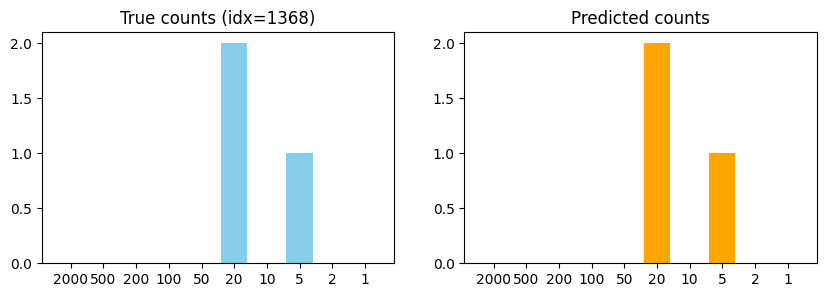

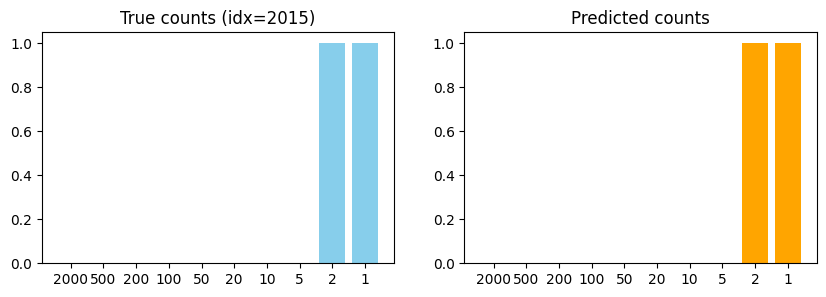

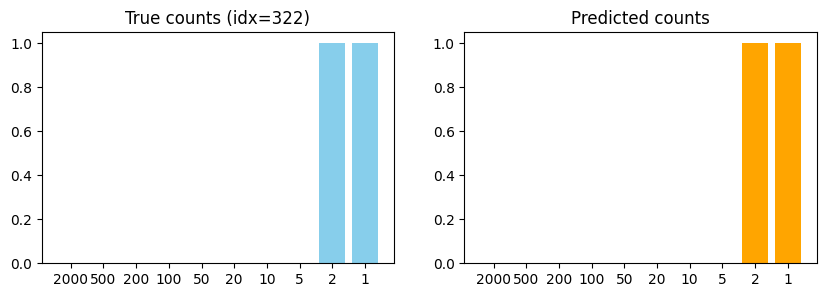

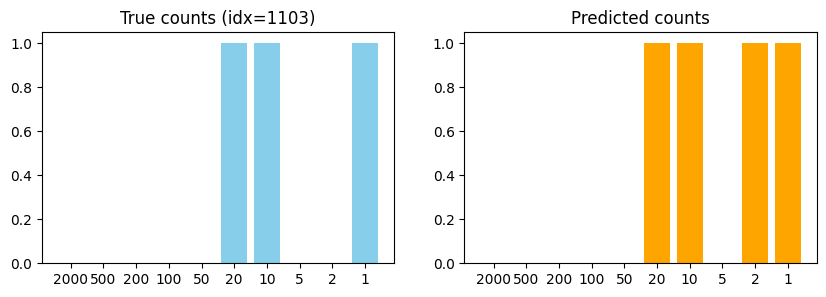

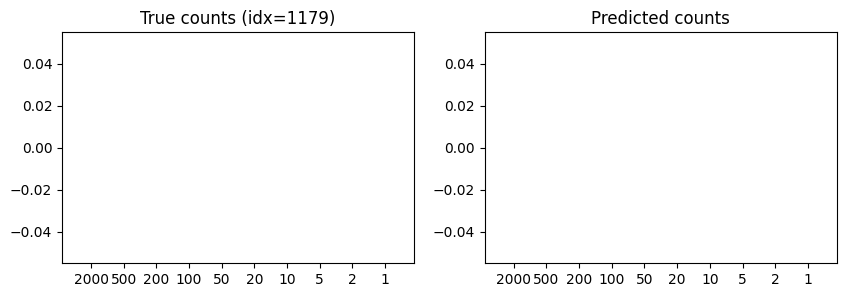

In [13]:
n_examples = 5
example_idxs = np.random.choice(X_test.index, n_examples, replace=False)

for idx in example_idxs:
    true_counts = y_test.loc[idx].values
    pred_counts = y_pred_int[np.where(X_test.index==idx)[0][0]]
    
    fig, ax = plt.subplots(1,2,figsize=(10,3))
    ax[0].bar([str(d) for d in DENOMINATIONS], true_counts, color='skyblue')
    ax[0].set_title(f'True counts (idx={idx})')
    ax[1].bar([str(d) for d in DENOMINATIONS], pred_counts, color='orange')
    ax[1].set_title('Predicted counts')
    plt.show()

In [14]:
def predict_change_denominations(total_amount, tendered_amount, pipeline):

    # Compute change to give
    change_to_give = tendered_amount - total_amount
    if change_to_give <= 0:
        return {f'denom_{d}': 0 for d in DENOMINATIONS}
    
    # Build feature vector
    import datetime
    now = datetime.datetime.now()
    feature_vector = pd.DataFrame([{
        'total_amount': total_amount,
        'tendered_amount': tendered_amount,
        'day_of_week': now.weekday(),
        'is_weekend': 1 if now.weekday() in [5,6] else 0,
        'month': now.month
    }])
    
    # Predict denomination counts
    pred_counts = pipeline.predict(feature_vector)
    pred_counts_int = np.maximum(0, np.round(pred_counts).astype(int)).flatten()
    
    return {f'denom_{d}': int(c) for d, c in zip(DENOMINATIONS, pred_counts_int)}

In [15]:
joblib.dump(pipeline, 'denomination_split_model.pkl')
print("Saved model as denomination_split_model.pkl")

Saved model as denomination_split_model.pkl
